In [ ]:
# COVID-19 Romania Prediction using Modified-SEIR and Deep Learning
# Paper: https://arxiv.org/abs/2006.12926

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras import layers, models
import requests
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import json
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import time
from functools import partial

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure for parallel processing
mp.set_start_method('spawn', force=True)  # Required for Colab compatibility

## 1. Data Loading and Preprocessing

Data loaded: 1143 days from 2020-01-22 to 2023-03-09

Analysis period: 2020-03-22 to 2020-05-21
Days in analysis period: 61
Total deaths by May 21, 2020: 1156
Daily deaths on May 21, 2020: 9


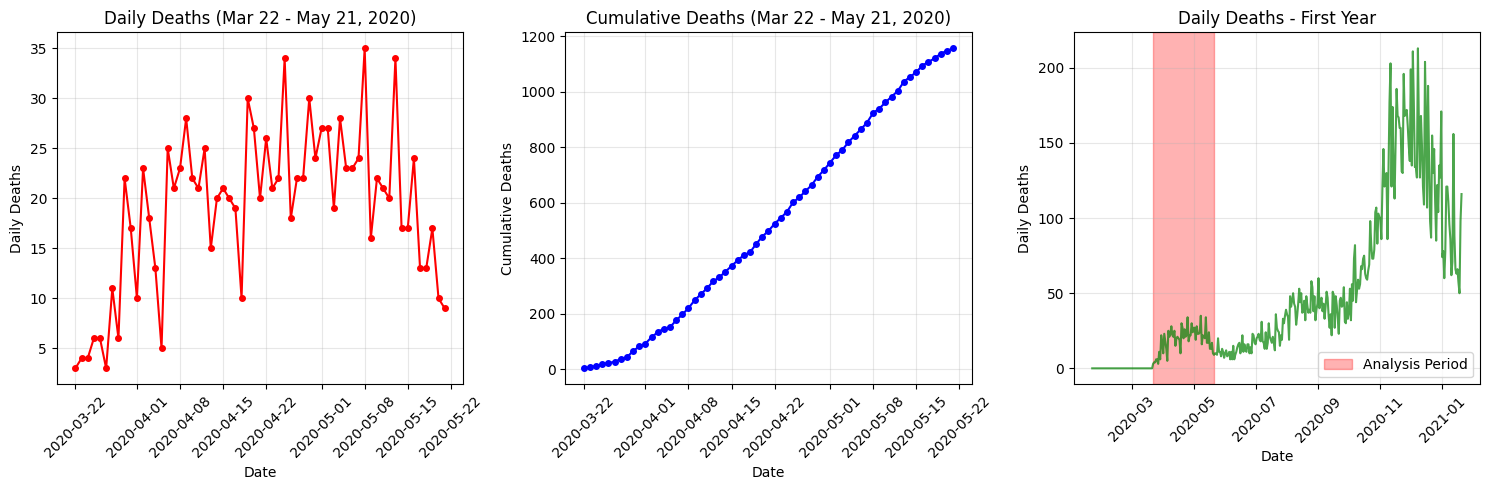


=== Key Statistics for Paper Validation ===
March 22, 2020 - Cumulative deaths: 3
May 3, 2020 - Cumulative deaths: 790
May 15, 2020 - Cumulative deaths: 1070
May 21, 2020 - Cumulative deaths: 1156

Validation dates data:
2020-06-03: 1296 cumulative deaths
2020-06-11: 1369 cumulative deaths


In [ ]:
# Fixed data loading function with proper date parsing
def load_covid_data():
    """Load COVID-19 data for Romania from Johns Hopkins CSSE"""
    # URL for Johns Hopkins COVID-19 data
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

    try:
        df = pd.read_csv(url)
        romania_data = df[df['Country/Region'] == 'Romania']

        # Extract date columns with proper format
        date_columns = df.columns[4:]
        # Johns Hopkins uses M/D/YY format
        dates = pd.to_datetime(date_columns, format='%m/%d/%y')

        deaths = romania_data.iloc[0, 4:].values

        # Calculate daily deaths from cumulative
        daily_deaths = np.diff(deaths, prepend=0)
        daily_deaths[daily_deaths < 0] = 0  # Handle any data inconsistencies

        return dates, deaths, daily_deaths
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Reload data with fixed function
dates, cumulative_deaths, daily_deaths = load_covid_data()
print(f"Data loaded: {len(dates)} days from {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")

# Verify the data for your analysis period (March 22 - May 21, 2020)
start_date = pd.to_datetime('2020-03-22')
end_date = pd.to_datetime('2020-05-21')

# Find indices
start_idx = np.where(dates >= start_date)[0][0]
end_idx = np.where(dates <= end_date)[0][-1]

print(f"\nAnalysis period: {dates[start_idx].strftime('%Y-%m-%d')} to {dates[end_idx].strftime('%Y-%m-%d')}")
print(f"Days in analysis period: {end_idx - start_idx + 1}")
print(f"Total deaths by May 21, 2020: {int(cumulative_deaths[end_idx])}")
print(f"Daily deaths on May 21, 2020: {int(daily_deaths[end_idx])}")

# Plot the data for visual verification
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Daily deaths for the analysis period
plt.subplot(1, 3, 1)
analysis_dates = dates[start_idx:end_idx+1]
analysis_daily = daily_deaths[start_idx:end_idx+1]
plt.plot(analysis_dates, analysis_daily, 'ro-', markersize=4)
plt.title('Daily Deaths (Mar 22 - May 21, 2020)')
plt.xlabel('Date')
plt.ylabel('Daily Deaths')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative deaths for the same period
plt.subplot(1, 3, 2)
analysis_cumulative = cumulative_deaths[start_idx:end_idx+1]
plt.plot(analysis_dates, analysis_cumulative, 'bo-', markersize=4)
plt.title('Cumulative Deaths (Mar 22 - May 21, 2020)')
plt.xlabel('Date')
plt.ylabel('Cumulative Deaths')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Full timeline to see the bigger picture
plt.subplot(1, 3, 3)
# Show first 365 days
first_year = min(365, len(dates))
plt.plot(dates[:first_year], daily_deaths[:first_year], 'g-', alpha=0.7)
plt.axvspan(dates[start_idx], dates[end_idx], alpha=0.3, color='red', label='Analysis Period')
plt.title('Daily Deaths - First Year')
plt.xlabel('Date')
plt.ylabel('Daily Deaths')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key statistics for your paper
print("\n=== Key Statistics for Paper Validation ===")
print(f"March 22, 2020 - Cumulative deaths: {int(cumulative_deaths[start_idx])}")
print(f"May 3, 2020 - Cumulative deaths: {int(cumulative_deaths[np.where(dates == pd.to_datetime('2020-05-03'))[0][0]])}")
print(f"May 15, 2020 - Cumulative deaths: {int(cumulative_deaths[np.where(dates == pd.to_datetime('2020-05-15'))[0][0]])}")
print(f"May 21, 2020 - Cumulative deaths: {int(cumulative_deaths[end_idx])}")

# Check if we have data for the validation dates mentioned in the paper
validation_dates = ['2020-06-03', '2020-06-11']
print("\nValidation dates data:")
for date_str in validation_dates:
    try:
        idx = np.where(dates == pd.to_datetime(date_str))[0][0]
        print(f"{date_str}: {int(cumulative_deaths[idx])} cumulative deaths")
    except:
        print(f"{date_str}: No data available")


## 2. Modified-SEIR Model Implementation

In [ ]:

class ModifiedSEIR:
    """Modified SEIR model as described in the paper"""

    def __init__(self, params: Dict[str, float]):
        self.params = params
        self.N = params.get('N', 20175912)  # Romania population

    def derivatives(self, t, y):
        """Calculate derivatives for the Modified-SEIR model"""
        S, E, I, M, V, H, F, R_M, R_V, R_F = y

        # Extract parameters
        R0 = self.params['R0']
        T_inc = self.params['T_inc']
        T_inf = self.params['T_inf']
        P_F = self.params['P_F']
        T_F = self.params['T_F']
        T_M = self.params['T_M']
        T_V = self.params['T_V']
        P_V = self.params['P_V']
        P_T = self.params['P_T']
        T = self.params['T']
        T_H = self.params.get('T_H', 5)

        # Calculate P_M
        P_M = 1 - P_V - P_F

        # Beta calculation (transmission rate)
        if t < T:
            beta = R0 / T_inf
        else:
            beta = (1 - P_T) * R0 / T_inf

        # Other rates
        sigma = 1 / T_inc
        gamma = 1 / T_inf

        # Derivatives
        dS = -beta * I * S / self.N
        dE = beta * I * S / self.N - sigma * E
        dI = sigma * E - gamma * I
        dM = P_M * gamma * I - M / T_M
        dV = P_V * gamma * I - V / T_H
        dH = V / T_H - H / T_V
        dF = P_F * gamma * I - F / T_F
        dR_M = M / T_M
        dR_V = H / T_V
        dR_F = F / T_F

        return [dS, dE, dI, dM, dV, dH, dF, dR_M, dR_V, dR_F]

    def simulate(self, days: int, I0: float = None):
        """Simulate the model for a given number of days"""
        if I0 is None:
            I0 = self.params['I0']

        # Initial conditions
        y0 = [
            self.N - I0,  # S
            0,            # E
            I0,           # I
            0,            # M
            0,            # V
            0,            # H
            0,            # F
            0,            # R_M
            0,            # R_V
            0             # R_F
        ]

        # Time points
        t = np.linspace(0, days, days + 1)

        # Solve ODE
        solution = solve_ivp(
            self.derivatives,
            [0, days],
            y0,
            t_eval=t,
            method='RK45'
        )

        # Extract results
        results = {
            'S': solution.y[0],
            'E': solution.y[1],
            'I': solution.y[2],
            'M': solution.y[3],
            'V': solution.y[4],
            'H': solution.y[5],
            'F': solution.y[6],
            'R_M': solution.y[7],
            'R_V': solution.y[8],
            'R_F': solution.y[9],
            't': solution.t
        }

        # Calculate daily deaths
        results['daily_deaths'] = np.diff(results['R_F'], prepend=0)

        return results

## 3. Parameter Ranges and Default Values

In [ ]:
# Parameter ranges from the paper
PARAM_RANGES = {
    'I0': (1500, 2500),
    'R0': (1.5, 2.5),
    'T_inc': (2, 14),
    'T_inf': (3, 14),
    'P_F': (0.001, 0.03),  # 0.1% to 3%
    'T_F': (14, 35),
    'T_M': (4, 12),
    'T_V': (7, 35),
    'P_V': (0.04, 0.2),
    'P_T': (0.4, 0.8),  # 40% to 80% reduction
    'T': (20, 22)
}

# Default parameters for testing
DEFAULT_PARAMS = {
    'I0': 1725,
    'R0': 2.21,
    'T_inc': 2,
    'T_inf': 3.47,
    'P_F': 0.00245,
    'T_F': 20.3,
    'T_M': 10,
    'T_V': 10,
    'P_V': 0.1,
    'P_T': 0.6,
    'T': 21,
    'N': 20175912
}


## 4. Self-Supervised Neural Network Implementation

In [ ]:
def create_neural_network(input_length: int):
    """Create the neural network architecture as described in the paper"""
    model = models.Sequential([
        layers.Conv1D(512, 5, activation='relu', input_shape=(input_length, 1)),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 5, activation='relu'),
        layers.MaxPooling1D(),
        layers.Conv1D(32, 5, activation='relu'),
        layers.MaxPooling1D(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        # Output layer - one output for each parameter
        layers.Dense(11)  # 11 parameters to predict
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

def generate_training_data(n_samples: int, sequence_length: int = 43, verbose: bool = True):
    """Generate synthetic training data for self-supervised learning with detailed logging"""

    if verbose:
        print(f"🔄 Starting generation of {n_samples:,} training samples...")
        print(f"📊 Sequence length: {sequence_length} days")
        print(f"⚙️  Parameter ranges: {len(PARAM_RANGES)} parameters to optimize")

    X = []
    y = []
    param_names = list(PARAM_RANGES.keys())

    # Logging variables
    start_time = time.time()
    failed_simulations = 0
    valid_samples = 0

    # Progress tracking
    checkpoint_interval = max(1, n_samples // 20)  # Report every 5%
    last_checkpoint = 0

    # Statistics tracking
    param_stats = {name: [] for name in param_names}
    death_stats = []

    for i in range(n_samples):
        try:
            # Generate random parameters within ranges
            params = {}
            param_values = []

            for param_name in param_names:
                min_val, max_val = PARAM_RANGES[param_name]
                if param_name == 'P_F':
                    # Log-uniform sampling for fatality rate
                    log_min = np.log10(min_val)
                    log_max = np.log10(max_val)
                    value = 10 ** np.random.uniform(log_min, log_max)
                else:
                    value = np.random.uniform(min_val, max_val)
                params[param_name] = value
                param_values.append(value)
                param_stats[param_name].append(value)

            params['N'] = 20175912

            # Simulate the model
            seir = ModifiedSEIR(params)
            results = seir.simulate(days=200)

            # Extract daily deaths curve
            daily_deaths = results['daily_deaths']

            # Quality checks
            if len(daily_deaths) <= sequence_length:
                failed_simulations += 1
                continue

            max_deaths = daily_deaths.max()
            if max_deaths <= 0 or np.isnan(max_deaths) or np.isinf(max_deaths):
                failed_simulations += 1
                continue

            # Find a random starting point where we have enough data
            start_idx = np.random.randint(0, len(daily_deaths) - sequence_length)
            death_sequence = daily_deaths[start_idx:start_idx + sequence_length]

            # Normalize the death sequence
            death_sequence = death_sequence / max_deaths

            # Additional quality checks
            if np.any(np.isnan(death_sequence)) or np.any(np.isinf(death_sequence)):
                failed_simulations += 1
                continue

            X.append(death_sequence)
            death_stats.append(max_deaths)

            # Normalize parameters for neural network
            normalized_params = []
            for j, param_name in enumerate(param_names):
                min_val, max_val = PARAM_RANGES[param_name]
                normalized_value = (param_values[j] - min_val) / (max_val - min_val)
                normalized_params.append(normalized_value)

            y.append(normalized_params)
            valid_samples += 1

        except Exception as e:
            failed_simulations += 1
            if verbose and failed_simulations % 100 == 1:  # Don't spam errors
                print(f"⚠️  Simulation error (#{failed_simulations}): {str(e)[:50]}...")
            continue

        # Progress reporting
        if verbose and (i + 1 - last_checkpoint) >= checkpoint_interval:
            elapsed_time = time.time() - start_time
            progress_pct = (i + 1) / n_samples * 100
            samples_per_sec = (i + 1) / elapsed_time
            eta_seconds = (n_samples - i - 1) / samples_per_sec if samples_per_sec > 0 else 0

            print(f"📈 Progress: {i+1:,}/{n_samples:,} ({progress_pct:.1f}%) | "
                  f"Valid: {valid_samples:,} | Failed: {failed_simulations:,} | "
                  f"Rate: {samples_per_sec:.1f}/sec | ETA: {eta_seconds/60:.1f}m")

            last_checkpoint = i + 1

    # Final statistics
    total_time = time.time() - start_time
    success_rate = valid_samples / n_samples * 100 if n_samples > 0 else 0

    if verbose:
        print(f"\n✅ Training data generation completed!")
        print(f"⏱️  Total time: {total_time/60:.1f} minutes ({total_time:.1f} seconds)")
        print(f"📊 Success rate: {success_rate:.1f}% ({valid_samples:,}/{n_samples:,})")
        print(f"❌ Failed simulations: {failed_simulations:,}")
        print(f"🎯 Final dataset size: {len(X):,} samples")

        if valid_samples > 0:
            print(f"\n📈 Dataset Statistics:")
            print(f"   Peak deaths range: {min(death_stats):.1f} - {max(death_stats):.1f}")
            print(f"   Mean peak deaths: {np.mean(death_stats):.1f}")

            # Show parameter distributions
            print(f"\n🔧 Parameter Distribution Summary:")
            for param_name in param_names[:3]:  # Show first 3 for brevity
                values = param_stats[param_name]
                if values:
                    print(f"   {param_name}: {min(values):.3f} - {max(values):.3f} "
                          f"(mean: {np.mean(values):.3f})")

            if len(param_names) > 3:
                print(f"   ... and {len(param_names)-3} other parameters")

    if len(X) == 0:
        raise ValueError("No valid training samples generated! Check parameter ranges and model implementation.")

    return np.array(X), np.array(y)

def generate_training_data_chunked(n_samples: int, chunk_size: int = 5000, sequence_length: int = 43):
    """Generate training data in chunks to manage memory and provide progress updates"""

    print(f"🔄 Generating {n_samples:,} samples in chunks of {chunk_size:,}...")

    X_all = []
    y_all = []
    total_generated = 0
    total_failed = 0

    start_time = time.time()

    for chunk_start in range(0, n_samples, chunk_size):
        chunk_end = min(chunk_start + chunk_size, n_samples)
        chunk_samples = chunk_end - chunk_start

        print(f"\n📦 Chunk {chunk_start//chunk_size + 1}: Generating samples {chunk_start+1:,} - {chunk_end:,}")

        try:
            X_chunk, y_chunk = generate_training_data(chunk_samples, sequence_length, verbose=True)

            X_all.extend(X_chunk)
            y_all.extend(y_chunk)
            total_generated += len(X_chunk)

            # Memory management
            if len(X_all) > 50000:  # If memory gets too large
                print("💾 Converting to numpy arrays to save memory...")
                X_all = np.array(X_all)
                y_all = np.array(y_all)

        except Exception as e:
            print(f"❌ Chunk failed: {e}")
            total_failed += chunk_samples
            continue

        # Progress summary
        elapsed = time.time() - start_time
        progress = chunk_end / n_samples * 100
        print(f"🎯 Overall progress: {total_generated:,} valid samples ({progress:.1f}%) in {elapsed/60:.1f}m")

    print(f"\n✅ All chunks completed! Final dataset: {len(X_all):,} samples")

    # Convert to numpy if not already
    if not isinstance(X_all, np.ndarray):
        X_all = np.array(X_all)
    if not isinstance(y_all, np.ndarray):
        y_all = np.array(y_all)

    return X_all, y_all

## 5. Optimization Functions

In [ ]:
def calculate_loss(params: Dict[str, float], target_deaths: np.ndarray, start_day: int = 0):
    """Calculate L2 loss between predicted and actual daily deaths"""
    try:
        seir = ModifiedSEIR(params)
        results = seir.simulate(days=len(target_deaths) + start_day)

        predicted_deaths = results['daily_deaths'][start_day:start_day + len(target_deaths)]

        # Ensure same length
        min_len = min(len(predicted_deaths), len(target_deaths))
        predicted_deaths = predicted_deaths[:min_len]
        target_deaths = target_deaths[:min_len]

        loss = np.sqrt(np.sum((predicted_deaths - target_deaths) ** 2))
        return loss
    except Exception as e:
        return float('inf')  # Return high loss for failed simulations

def enhanced_loss_with_validation(params: Dict[str, float], target_deaths: np.ndarray,
                                validation_data: Dict = None):
    """Enhanced loss function as described in paper (Equation 3)"""
    base_loss = calculate_loss(params, target_deaths)

    if validation_data is None or base_loss == float('inf'):
        return base_loss

    # Add validation penalties (simplified version)
    penalty = 0
    try:
        seir = ModifiedSEIR(params)
        results = seir.simulate(days=200)  # Extended simulation

        for date_str, actual_value in validation_data.items():
            days_offset = (pd.to_datetime(date_str) - pd.to_datetime('2020-03-22')).days
            if 0 <= days_offset < len(results['R_F']):
                predicted_value = results['R_F'][days_offset]
                relative_error = abs(predicted_value - actual_value) / actual_value
                penalty += 100 * relative_error
    except:
        penalty = 1000  # High penalty for failed validation

    return base_loss + penalty

def single_optimization_run(args):
    """Single optimization run - designed for parallel execution"""
    target_deaths, optimization_method, run_id, validation_data = args

    # Set unique random seed for this process
    np.random.seed(42 + run_id)

    start_time = time.time()

    try:
        if optimization_method == 'grid_search':
            initial_params, initial_loss = grid_search_optimization(target_deaths, grid_resolution=4)
        elif optimization_method == 'neural_network':
            # For NN method, we need to recreate the model in each process
            # This is a simplified version - in practice, you'd save/load the trained model
            initial_params = generate_random_params()
            initial_loss = calculate_loss(initial_params, target_deaths)
        else:
            # Random initialization
            initial_params = generate_random_params()
            initial_loss = calculate_loss(initial_params, target_deaths)

        # Refine with coordinate descent
        if initial_loss != float('inf'):
            refined_params, refined_loss = coordinate_descent_refinement(
                initial_params, target_deaths, max_iterations=50
            )

            # Further refinement with enhanced loss
            if validation_data:
                enhanced_loss_func = partial(enhanced_loss_with_validation,
                                          target_deaths=target_deaths,
                                          validation_data=validation_data)
                final_params, final_loss = coordinate_descent_refinement_enhanced(
                    refined_params, enhanced_loss_func, max_iterations=30
                )
            else:
                final_params, final_loss = refined_params, refined_loss
        else:
            final_params, final_loss = initial_params, initial_loss

        elapsed_time = time.time() - start_time

        return {
            'run_id': run_id,
            'method': optimization_method,
            'params': final_params,
            'loss': final_loss,
            'time': elapsed_time,
            'success': final_loss != float('inf')
        }

    except Exception as e:
        return {
            'run_id': run_id,
            'method': optimization_method,
            'params': None,
            'loss': float('inf'),
            'time': time.time() - start_time,
            'success': False,
            'error': str(e)
        }

def generate_random_params():
    """Generate random parameters within valid ranges"""
    params = {'N': 20175912}
    for param_name, (min_val, max_val) in PARAM_RANGES.items():
        if param_name == 'P_F':
            # Log-uniform sampling for fatality rate
            log_min = np.log10(min_val)
            log_max = np.log10(max_val)
            params[param_name] = 10 ** np.random.uniform(log_min, log_max)
        else:
            params[param_name] = np.random.uniform(min_val, max_val)
    return params

def coordinate_descent_refinement_enhanced(initial_params, loss_function, max_iterations=50):
    """Enhanced coordinate descent that works with custom loss functions"""
    params = initial_params.copy()
    best_loss = loss_function(params)

    param_names = [name for name in PARAM_RANGES.keys()]

    for iteration in range(max_iterations):
        old_loss = best_loss

        # Randomly select parameters to optimize
        n_params_to_optimize = min(3, len(param_names))
        selected_params = np.random.choice(param_names, size=n_params_to_optimize, replace=False)

        for param_name in selected_params:
            min_val, max_val = PARAM_RANGES[param_name]
            current_val = params[param_name]

            # Adaptive search range
            delta = (max_val - min_val) * max(0.05, 0.2 * (1 - iteration/max_iterations))
            local_min = max(min_val, current_val - delta)
            local_max = min(max_val, current_val + delta)

            # Test different values
            n_tests = max(10, 20 - iteration//5)  # Reduce resolution over time
            test_values = np.linspace(local_min, local_max, n_tests)

            for test_val in test_values:
                test_params = params.copy()
                test_params[param_name] = test_val

                try:
                    loss = loss_function(test_params)
                    if loss < best_loss:
                        best_loss = loss
                        params[param_name] = test_val
                except:
                    continue

        # Check convergence
        if abs(old_loss - best_loss) < 1e-3:
            break

    return params, best_loss

def parallel_optimization(target_deaths, n_runs=8, methods=['grid_search', 'random'],
                        validation_data=None, max_workers=None):
    """Run multiple optimization attempts in parallel"""

    if max_workers is None:
        max_workers = min(n_runs, mp.cpu_count())

    print(f"Starting {n_runs} parallel optimization runs using {max_workers} workers...")
    print(f"Methods: {methods}")

    # Prepare arguments for each run
    args_list = []
    for run_id in range(n_runs):
        method = methods[run_id % len(methods)]  # Cycle through methods
        args_list.append((target_deaths, method, run_id, validation_data))

    # Execute in parallel
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all jobs
        future_to_run = {executor.submit(single_optimization_run, args): args[2]
                        for args in args_list}

        # Collect results as they complete
        for future in as_completed(future_to_run):
            run_id = future_to_run[future]
            try:
                result = future.result(timeout=300)  # 5 minute timeout per run
                results.append(result)
                if result['success']:
                    print(f"✓ Run {run_id} ({result['method']}): Loss={result['loss']:.2f}, Time={result['time']:.1f}s")
                else:
                    print(f"✗ Run {run_id} ({result['method']}): Failed")
            except Exception as e:
                print(f"✗ Run {run_id}: Exception - {str(e)}")
                results.append({
                    'run_id': run_id, 'success': False, 'loss': float('inf'),
                    'error': str(e), 'params': None
                })

    # Find best result
    successful_results = [r for r in results if r['success']]
    if successful_results:
        best_result = min(successful_results, key=lambda x: x['loss'])
        print(f"\n🎯 Best result: Loss={best_result['loss']:.2f} from {best_result['method']} (Run {best_result['run_id']})")
        return best_result, results
    else:
        print("\n❌ All optimization runs failed!")
        return None, results

# Keep existing functions but update them
def grid_search_optimization(target_deaths: np.ndarray, grid_resolution: int = 3):
    """Improved grid search optimization"""
    best_params = None
    best_loss = float('inf')

    # Create more refined grid
    param_grids = {}
    for param_name, (min_val, max_val) in PARAM_RANGES.items():
        if param_name == 'P_F':
            param_grids[param_name] = np.logspace(np.log10(min_val), np.log10(max_val), grid_resolution)
        else:
            param_grids[param_name] = np.linspace(min_val, max_val, grid_resolution)

    # Increase number of random samples
    n_samples = min(5000, grid_resolution ** len(PARAM_RANGES))
    for _ in range(n_samples):
        params = {'N': 20175912}
        for param_name, grid in param_grids.items():
            params[param_name] = np.random.choice(grid)

        try:
            loss = calculate_loss(params, target_deaths)
            if loss < best_loss:
                best_loss = loss
                best_params = params.copy()
        except:
            continue

    return best_params, best_loss

def coordinate_descent_refinement(initial_params: Dict[str, float], target_deaths: np.ndarray,
                                max_iterations: int = 100, tolerance: float = 1e-3):
    """Improved coordinate descent refinement"""
    params = initial_params.copy()
    best_loss = calculate_loss(params, target_deaths)

    param_names = list(PARAM_RANGES.keys())

    for iteration in range(max_iterations):
        old_loss = best_loss

        # Adaptive parameter selection
        if iteration < max_iterations // 3:
            # Early phase: optimize more parameters
            n_params = min(4, len(param_names))
        else:
            # Later phase: focus on fewer parameters
            n_params = min(2, len(param_names))

        selected_params = np.random.choice(param_names, size=n_params, replace=False)

        for param_name in selected_params:
            min_val, max_val = PARAM_RANGES[param_name]
            current_val = params[param_name]

            # Adaptive search range (starts large, gets smaller)
            progress = iteration / max_iterations
            delta_factor = 0.2 * (1 - progress) + 0.05 * progress  # 20% -> 5%
            delta = (max_val - min_val) * delta_factor

            local_min = max(min_val, current_val - delta)
            local_max = min(max_val, current_val + delta)

            # Adaptive resolution
            n_tests = max(15, 30 - iteration//3)
            test_values = np.linspace(local_min, local_max, n_tests)

            for test_val in test_values:
                test_params = params.copy()
                test_params[param_name] = test_val

                try:
                    loss = calculate_loss(test_params, target_deaths)
                    if loss < best_loss:
                        best_loss = loss
                        params[param_name] = test_val
                except:
                    continue

        # Check convergence
        if abs(old_loss - best_loss) < tolerance:
            break

    return params, best_loss

## 6. Neural Network Training

🔧 Moderate memory detected, using 50K samples
💾 System memory: 12.7 GB

TRAINING DATA GENERATION
📦 Using chunked generation for large dataset...
🔄 Generating 50,000 samples in chunks of 10,000...

📦 Chunk 1: Generating samples 1 - 10,000
🔄 Starting generation of 10,000 training samples...
📊 Sequence length: 43 days
⚙️  Parameter ranges: 11 parameters to optimize
📈 Progress: 500/10,000 (5.0%) | Valid: 500 | Failed: 0 | Rate: 155.0/sec | ETA: 1.0m
📈 Progress: 1,000/10,000 (10.0%) | Valid: 1,000 | Failed: 0 | Rate: 151.1/sec | ETA: 1.0m
📈 Progress: 1,500/10,000 (15.0%) | Valid: 1,500 | Failed: 0 | Rate: 152.7/sec | ETA: 0.9m
📈 Progress: 2,000/10,000 (20.0%) | Valid: 2,000 | Failed: 0 | Rate: 150.9/sec | ETA: 0.9m
📈 Progress: 2,500/10,000 (25.0%) | Valid: 2,500 | Failed: 0 | Rate: 138.8/sec | ETA: 0.9m
📈 Progress: 3,000/10,000 (30.0%) | Valid: 3,000 | Failed: 0 | Rate: 128.0/sec | ETA: 0.9m
📈 Progress: 3,500/10,000 (35.0%) | Valid: 3,500 | Failed: 0 | Rate: 131.6/sec | ETA: 0.8m
📈 Progress

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 39, 512)        │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 128)        │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 32)          │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,931 (2.04 MB)

 Trainable params: 533,931 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

📊 Model parameters: 533,931
🔄 Reshaping data for Conv1D...
📊 Reshaped data: (50000, 43, 1)
⚙️  Training configuration:
   Epochs: 50
   Batch size: 64
   Validation split: 0.2
   Training samples: 40,000
   Validation samples: 10,000

🚀 Starting training...
🔄 Starting epoch 1/50...
✅ Epoch 1 completed in 6.1s | Loss: 0.0816 | Val Loss: 0.0756 | MAE: 0.2433 | Val MAE: 0.2318
🔄 Starting epoch 2/50...
✅ Epoch 2 completed in 2.4s | Loss: 0.0747 | Val Loss: 0.0746 | MAE: 0.2314 | Val MAE: 0.2309
📈 Validation loss improved by inf
🔄 Starting epoch 3/50...
✅ Epoch 3 completed in 3.2s | Loss: 0.0743 | Val Loss: 0.0740 | MAE: 0.2307 | Val MAE: 0.2297
📈 Validation loss improved by 0.0016
🔄 Starting epoch 4/50...
✅ Epoch 4 completed in 2.7s | Loss: 0.0742 | Val Loss: 0.0739 | MAE: 0.2304 | Val MAE: 0.2294
📈 Validation loss improved by 0.0008
🔄 Starting epoch 5/50...
✅ Epoch 5 completed in 4.9s | Loss: 0.0741 | Val Loss: 0.0739 | MAE: 0.2302 | Val MAE: 0.2293
📈 Validation loss improved by 0.0001
🔄 

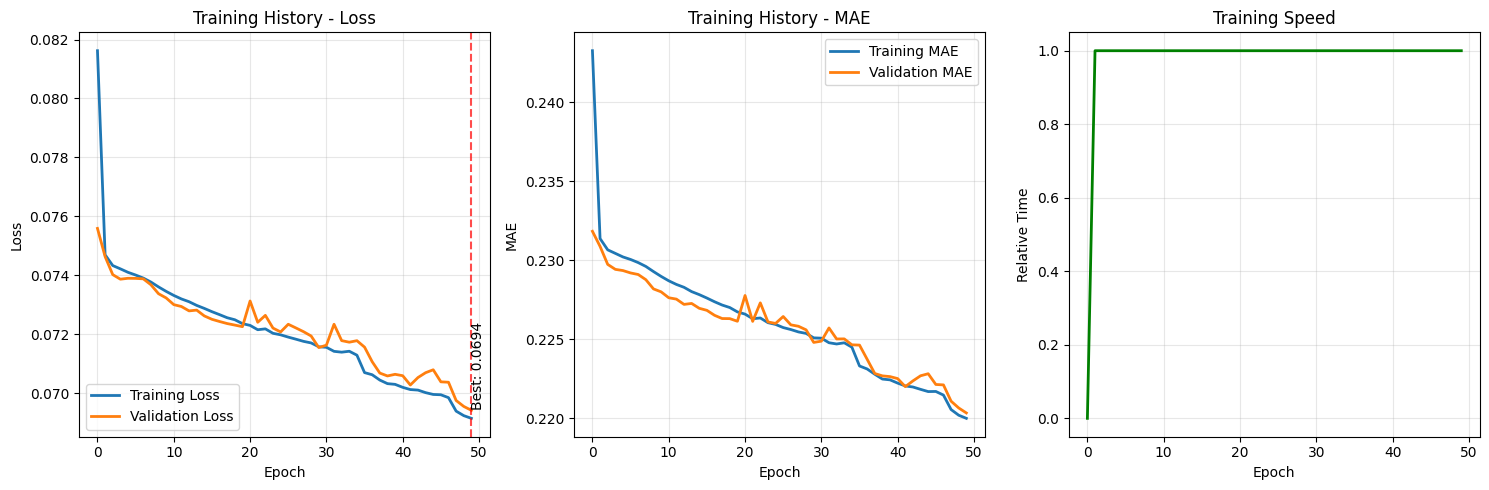


🎯 Model ready for optimization!
📈 Best validation loss achieved: 0.0694 at epoch 50

📋 Training Summary:
   samples_generated: 50000
   generation_time_minutes: 5.8
   training_time_minutes: 2.9
   final_val_loss: 0.0694
   best_val_loss: 0.0694
   best_epoch: 50
   total_epochs: 50


In [ ]:
# Enhanced Neural Network Training with Progress Monitoring

# Determine training data size based on available resources
import psutil
memory_gb = psutil.virtual_memory().total / (1024**3)

if memory_gb < 8:
    n_samples = 20000
    print("🔧 Limited memory detected, using 20K samples")
elif memory_gb < 16:
    n_samples = 50000
    print("🔧 Moderate memory detected, using 50K samples")
else:
    n_samples = 100000
    print("🔧 Sufficient memory detected, using 100K samples")

print(f"💾 System memory: {memory_gb:.1f} GB")

# Generate training data with enhanced logging
print("\n" + "="*60)
print("TRAINING DATA GENERATION")
print("="*60)

generation_start = time.time()

# Choose generation method based on sample size
if n_samples > 30000:
    print("📦 Using chunked generation for large dataset...")
    X_train, y_train = generate_training_data_chunked(
        n_samples=n_samples,
        chunk_size=10000,
        sequence_length=43
    )
else:
    print("🚀 Using direct generation for smaller dataset...")
    X_train, y_train = generate_training_data(
        n_samples=n_samples,
        sequence_length=43,
        verbose=True
    )

generation_time = time.time() - generation_start

print(f"\n✅ Training data generation completed!")
print(f"📊 Final shapes: X={X_train.shape}, y={y_train.shape}")
print(f"⏱️  Generation time: {generation_time/60:.1f} minutes")
print(f"💾 Memory usage: ~{X_train.nbytes + y_train.nbytes / 1e6:.1f} MB")

# Data quality checks
print(f"\n🔍 Data Quality Checks:")
print(f"   X range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"   y range: [{y_train.min():.3f}, {y_train.max():.3f}]")
print(f"   NaN values: X={np.isnan(X_train).sum()}, y={np.isnan(y_train).sum()}")
print(f"   Inf values: X={np.isinf(X_train).sum()}, y={np.isinf(y_train).sum()}")

# Create and train the model
print("\n" + "="*60)
print("NEURAL NETWORK TRAINING")
print("="*60)

print("🏗️  Creating neural network...")
nn_model = create_neural_network(input_length=43)
nn_model.summary()

# Calculate model parameters
total_params = nn_model.count_params()
print(f"📊 Model parameters: {total_params:,}")

# Reshape data for Conv1D
print("🔄 Reshaping data for Conv1D...")
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(f"📊 Reshaped data: {X_train.shape}")

# Configure training
batch_size = min(64, len(X_train) // 100)  # Adaptive batch size
epochs = 50
validation_split = 0.2

print(f"⚙️  Training configuration:")
print(f"   Epochs: {epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Validation split: {validation_split}")
print(f"   Training samples: {int(len(X_train) * (1-validation_split)):,}")
print(f"   Validation samples: {int(len(X_train) * validation_split):,}")

# Custom callback for detailed logging
class DetailedLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        if epoch % 5 == 0 or epoch < 5:
            print(f"🔄 Starting epoch {epoch+1}/{epochs}...")

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time

        if epoch % 5 == 0 or epoch < 5 or epoch == epochs-1:
            train_loss = logs.get('loss', 0)
            val_loss = logs.get('val_loss', 0)
            train_mae = logs.get('mae', 0)
            val_mae = logs.get('val_mae', 0)

            print(f"✅ Epoch {epoch+1} completed in {epoch_time:.1f}s | "
                  f"Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

            # Improvement check
            if epoch > 0:
                prev_val_loss = self.model.history.history['val_loss'][-2] if len(self.model.history.history['val_loss']) > 1 else float('inf')
                if val_loss < prev_val_loss:
                    print(f"📈 Validation loss improved by {prev_val_loss - val_loss:.4f}")
                elif epoch > 10:
                    print(f"📉 Validation loss increased by {val_loss - prev_val_loss:.4f}")

# Train the model
print(f"\n🚀 Starting training...")
training_start = time.time()

try:
    history = nn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        verbose=0,  # We'll use our custom callback for logging
        callbacks=[
            DetailedLoggingCallback(),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]
    )
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user")

training_time = time.time() - training_start

print(f"\n✅ Training completed!")
print(f"⏱️  Training time: {training_time/60:.1f} minutes")
print(f"📊 Final training loss: {history.history['loss'][-1]:.4f}")
print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Plot training history with enhanced visualization
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History - Loss')
plt.grid(True, alpha=0.3)

# Add best epoch marker
best_epoch = np.argmin(history.history['val_loss'])
best_val_loss = min(history.history['val_loss'])
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
plt.text(best_epoch, best_val_loss, f'Best: {best_val_loss:.4f}',
         rotation=90, verticalalignment='bottom')

# MAE plot
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training History - MAE')
plt.grid(True, alpha=0.3)

# Learning rate plot (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')
else:
    # Show epoch times instead
    epoch_times = np.diff([0] + [i for i in range(len(history.history['loss']))])
    plt.plot(epoch_times, linewidth=2, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Relative Time')
    plt.title('Training Speed')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Model ready for optimization!")
print(f"📈 Best validation loss achieved: {min(history.history['val_loss']):.4f} at epoch {best_epoch+1}")

# Save training statistics
training_stats = {
    'samples_generated': len(X_train),
    'generation_time_minutes': generation_time/60,
    'training_time_minutes': training_time/60,
    'final_val_loss': history.history['val_loss'][-1],
    'best_val_loss': min(history.history['val_loss']),
    'best_epoch': best_epoch + 1,
    'total_epochs': len(history.history['loss'])
}

print(f"\n📋 Training Summary:")
for key, value in training_stats.items():
    if 'time' in key:
        print(f"   {key}: {value:.1f}")
    elif 'loss' in key:
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")

## 7. Apply to Real Data

In [ ]:
import os
import threading
from concurrent.futures import ThreadPoolExecutor
import tempfile
import pandas as pd
import numpy as np
import time

def save_model_for_multiprocessing():
    """Save the trained model to a temporary file for subprocess loading"""
    temp_dir = tempfile.mkdtemp()
    model_path = os.path.join(temp_dir, 'temp_nn_model.h5')
    nn_model.save(model_path)
    return model_path

def optimize_with_neural_network_cpu(target_deaths, model_path, sequence_length=43):
    """CPU-only NN optimization that loads model from disk"""
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    import tensorflow as tf
    tf.config.set_visible_devices([], 'GPU')

    loaded_model = tf.keras.models.load_model(model_path)
    target_deaths = np.array(target_deaths, dtype=np.float32)

    death_sequence = target_deaths[:sequence_length]
    if death_sequence.max() > 0:
        death_sequence = death_sequence / death_sequence.max()

    input_data = death_sequence.reshape(1, sequence_length, 1)
    normalized_params = loaded_model.predict(input_data, verbose=0)[0]

    param_names = list(PARAM_RANGES.keys())
    params = {'N': 20175912}
    for i, param_name in enumerate(param_names):
        min_val, max_val = PARAM_RANGES[param_name]
        params[param_name] = normalized_params[i] * (max_val - min_val) + min_val
    return params

def generate_smart_random_params(target_deaths):
    """Generate smarter random parameters based on death curve analysis"""
    params = {'N': 20175912}
    max_deaths = target_deaths.max()
    peak_day = np.argmax(target_deaths)
    curve_length = len(target_deaths)

    if max_deaths > 0:
        base_r0 = 1.6 + min(0.8, max_deaths / 25.0)
        params['R0'] = np.clip(base_r0 + np.random.normal(0, 0.15), 1.5, 2.5)
        peak_ratio = peak_day / curve_length
        if peak_ratio < 0.4:
            params['P_T'] = np.random.uniform(0.55, 0.75)
            params['T'] = np.random.randint(20, 22)
        else:
            params['P_T'] = np.random.uniform(0.4, 0.6)
            params['T'] = np.random.randint(21, 23)
        params['I0'] = np.clip(1500 + max_deaths * 50 + np.random.randint(-300, 300), 1500, 2500)
    else:
        for param_name, (min_val, max_val) in PARAM_RANGES.items():
            params[param_name] = np.random.uniform(min_val, max_val)

    for param_name, (min_val, max_val) in PARAM_RANGES.items():
        if param_name not in params:
             if param_name == 'P_F':
                params[param_name] = 10 ** np.random.uniform(np.log10(min_val), np.log10(max_val))
             else:
                params[param_name] = np.random.uniform(min_val, max_val)
    return params

def enhanced_loss_with_validation_fast(params, target_deaths, validation_data):
    """Fast validation with penalty"""
    base_loss = calculate_loss(params, target_deaths)
    if base_loss == float('inf'):
        return float('inf')
    penalty = 0
    try:
        seir = ModifiedSEIR(params)
        results = seir.simulate(days=100)
        for date_str, actual_value in validation_data.items():
            days_offset = (pd.to_datetime(date_str) - pd.to_datetime('2020-03-22')).days
            if 0 <= days_offset < len(results['R_F']):
                predicted_value = results['R_F'][days_offset]
                if actual_value > 0:
                    relative_error = abs(predicted_value - actual_value) / actual_value
                    penalty += 25 * relative_error
    except:
        penalty = 200
    return base_loss + penalty

def single_optimization_run_gpu_safe(args):
    """GPU-safe single optimization run that returns initial and final params"""
    target_deaths, optimization_method, run_id, model_path, validation_data = args
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    np.random.seed(42 + run_id)
    start_time = time.time()

    try:
        if optimization_method == 'neural_network':
            initial_params = optimize_with_neural_network_cpu(target_deaths, model_path)
            method_name = "Neural Network"
        elif optimization_method == 'grid_search':
            initial_params, _ = grid_search_optimization(target_deaths, grid_resolution=3)
            method_name = "Grid Search"
        elif optimization_method == 'smart_random':
            initial_params = generate_smart_random_params(np.array(target_deaths))
            method_name = "Smart Random"
        else:
            initial_params = generate_random_params()
            method_name = "Random"

        if not initial_params:
             initial_params = generate_random_params()

        initial_loss = calculate_loss(initial_params, np.array(target_deaths))
        refined_params, refined_loss = coordinate_descent_refinement(
            initial_params, np.array(target_deaths), max_iterations=25
        )
        enhanced_loss = enhanced_loss_with_validation_fast(refined_params, np.array(target_deaths), validation_data)
        elapsed_time = time.time() - start_time

        return {
            'run_id': run_id, 'method': method_name, 'initial_params': initial_params,
            'params': refined_params, 'initial_loss': initial_loss, 'refined_loss': refined_loss,
            'enhanced_loss': enhanced_loss, 'time': elapsed_time, 'success': True
        }
    except Exception as e:
        return {
            'run_id': run_id, 'method': optimization_method, 'params': None, 'loss': float('inf'),
            'time': time.time() - start_time, 'success': False, 'error': str(e)
        }

def threaded_optimization(target_deaths, n_runs=8, methods=None, validation_data=None, max_workers=4):
    """Use threading instead of multiprocessing for GPU compatibility"""
    if methods is None:
        methods = ['neural_network', 'grid_search', 'smart_random', 'random']
    print(f"🧵 Starting {n_runs} threaded optimization runs using {max_workers} threads...\n   Methods: {methods}")

    model_path = save_model_for_multiprocessing()
    args_list = [(target_deaths.tolist(), methods[run_id % len(methods)], run_id, model_path, validation_data) for run_id in range(n_runs)]
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_run = {executor.submit(single_optimization_run_gpu_safe, args): args[2] for args in args_list}
        for future in future_to_run:
            try:
                result = future.result(timeout=120)
                results.append(result)
                if result['success']:
                    print(f"✓ Run {result['run_id']+1:2d} ({result['method']:12s}): Loss {result['refined_loss']:6.1f} → {result['enhanced_loss']:6.1f} ({result['time']:4.1f}s)")
                else:
                    print(f"✗ Run {result['run_id']+1:2d}: Failed - {result.get('error', 'Unknown')[:30]}...")
            except Exception as e:
                run_id = future_to_run[future]
                print(f"✗ Run {run_id+1:2d}: Exception - {str(e)[:40]}...")
    try:
        os.remove(model_path)
        os.rmdir(os.path.dirname(model_path))
    except: pass

    successful_results = [r for r in results if r['success']]
    if successful_results:
        best_result = min(successful_results, key=lambda x: x.get('enhanced_loss', x['refined_loss']))
        print(f"\n🎯 Best threaded result: Loss={best_result.get('enhanced_loss', best_result['refined_loss']):.2f} from {best_result['method']} (Run {best_result['run_id']+1})")
        return best_result, results
    return None, results

def multi_start_optimization(target_deaths, n_runs=8, methods=None, validation_data=None):
    """Sequential (non-parallel) version of optimization for fallback"""
    if methods is None:
        methods = ['neural_network', 'grid_search', 'smart_random', 'random']
    print(f"🐌 Starting {n_runs} sequential optimization runs...\n   Methods: {methods}")

    model_path = save_model_for_multiprocessing()
    results = []
    for run_id in range(n_runs):
        args = (target_deaths.tolist(), methods[run_id % len(methods)], run_id, model_path, validation_data)
        result = single_optimization_run_gpu_safe(args)
        results.append(result)
        if result['success']:
            print(f"✓ Run {result['run_id']+1:2d} ({result['method']:12s}): Loss {result['refined_loss']:6.1f} → {result['enhanced_loss']:6.1f} ({result['time']:4.1f}s)")
        else:
            print(f"✗ Run {result['run_id']+1:2d}: Failed - {result.get('error', 'Unknown')[:30]}...")
    try:
        os.remove(model_path)
        os.rmdir(os.path.dirname(model_path))
    except: pass

    successful_results = [r for r in results if r['success']]
    if successful_results:
        best_result = min(successful_results, key=lambda x: x.get('enhanced_loss', x['refined_loss']))
        print(f"\n🎯 Best sequential result: Loss={best_result.get('enhanced_loss', best_result['refined_loss']):.2f} from {best_result['method']} (Run {best_result['run_id']+1})")
        return best_result, results
    return None, results


def hybrid_optimization(target_deaths, validation_data=None):
    """Hybrid approach: Try threading, fallback to sequential"""
    print("🔧 Attempting GPU-safe parallel optimization...")
    try:
        best_result, all_results = threaded_optimization(
            target_deaths, n_runs=8, validation_data=validation_data, max_workers=3
        )
        if best_result and best_result['success']:
            return best_result, all_results, "Threaded"
    except Exception as e:
        print(f"⚠️ Threaded optimization failed: {e}")
        print("🔄 Falling back to sequential optimization...")

    best_result, all_results = multi_start_optimization(
        target_deaths, n_runs=12, validation_data=validation_data
    )
    return best_result, all_results, "Sequential"

# === Main Execution ===
print("🚀 Starting Hybrid Optimization...")
start_date = pd.to_datetime('2020-03-22')
end_date = pd.to_datetime('2020-05-21')
start_idx = np.where(dates >= start_date)[0][0]
end_idx = np.where(dates <= end_date)[0][-1]
target_daily_deaths = daily_deaths[start_idx:end_idx+1]
target_dates = dates[start_idx:end_idx+1]

print(f"\nOptimizing parameters for {len(target_daily_deaths)} days ({target_dates[0].strftime('%Y-%m-%d')} to {target_dates[-1].strftime('%Y-%m-%d')})")

validation_data = {
    '2020-06-03': 1296,
    '2020-06-11': 1369,
}
print(f"Validation data points: {len(validation_data)}")
print("\n" + "="*60 + "\nHYBRID OPTIMIZATION (THREADING + SEQUENTIAL FALLBACK)\n" + "="*60)

start_time = time.time()
best_result, all_results, method_used = hybrid_optimization(target_daily_deaths, validation_data)
total_time = time.time() - start_time

print(f"\n✅ Optimization completed using {method_used} approach in {total_time:.1f}s")

if best_result and best_result['success']:
    final_params = best_result['params']
    initial_params = best_result['initial_params']
    final_loss = best_result.get('enhanced_loss', best_result.get('refined_loss', float('inf')))
    optimization_method_str = f"{method_used} - {best_result['method']}"
    print(f"\n🎯 BEST PARAMETERS FOUND:")
    print(f"   Method: {best_result['method']}")
    print(f"   Final Loss: {final_loss:.4f}")
else:
    print("❌ Optimization failed! Using default parameters for visualization.")
    final_params = DEFAULT_PARAMS.copy()
    initial_params = DEFAULT_PARAMS.copy()
    final_loss = calculate_loss(final_params, target_daily_deaths)
    all_results = []
    optimization_method_str = "Default"

print(f"\n✅ Ready for visualization and prediction!")

🚀 Starting Hybrid Optimization...

Optimizing parameters for 61 days (2020-03-22 to 2020-05-21)
Validation data points: 2

HYBRID OPTIMIZATION (THREADING + SEQUENTIAL FALLBACK)
🔧 Attempting GPU-safe parallel optimization...
🧵 Starting 8 threaded optimization runs using 3 threads...
   Methods: ['neural_network', 'grid_search', 'smart_random', 'random']
✗ Run  1: Failed - Visible devices cannot be modi...
✓ Run  2 (Grid Search ): Loss   53.2 →   55.1 (86.4s)
✓ Run  3 (Smart Random): Loss   88.8 →   93.6 (18.3s)
✓ Run  4 (Random      ): Loss   67.2 →   74.4 (16.7s)
✗ Run  5: Failed - Visible devices cannot be modi...
✓ Run  6 (Grid Search ): Loss   51.6 →   56.1 (77.5s)
✓ Run  7 (Smart Random): Loss   84.3 →   87.1 (11.2s)
✓ Run  8 (Random      ): Loss   71.2 →   73.5 ( 8.3s)

🎯 Best threaded result: Loss=55.12 from Grid Search (Run 2)

✅ Optimization completed using Threaded approach in 94.2s

🎯 BEST PARAMETERS FOUND:
   Method: Grid Search
   Final Loss: 55.1205

✅ Ready for visualizat

## 8. Results Visualization


RESULTS VISUALIZATION


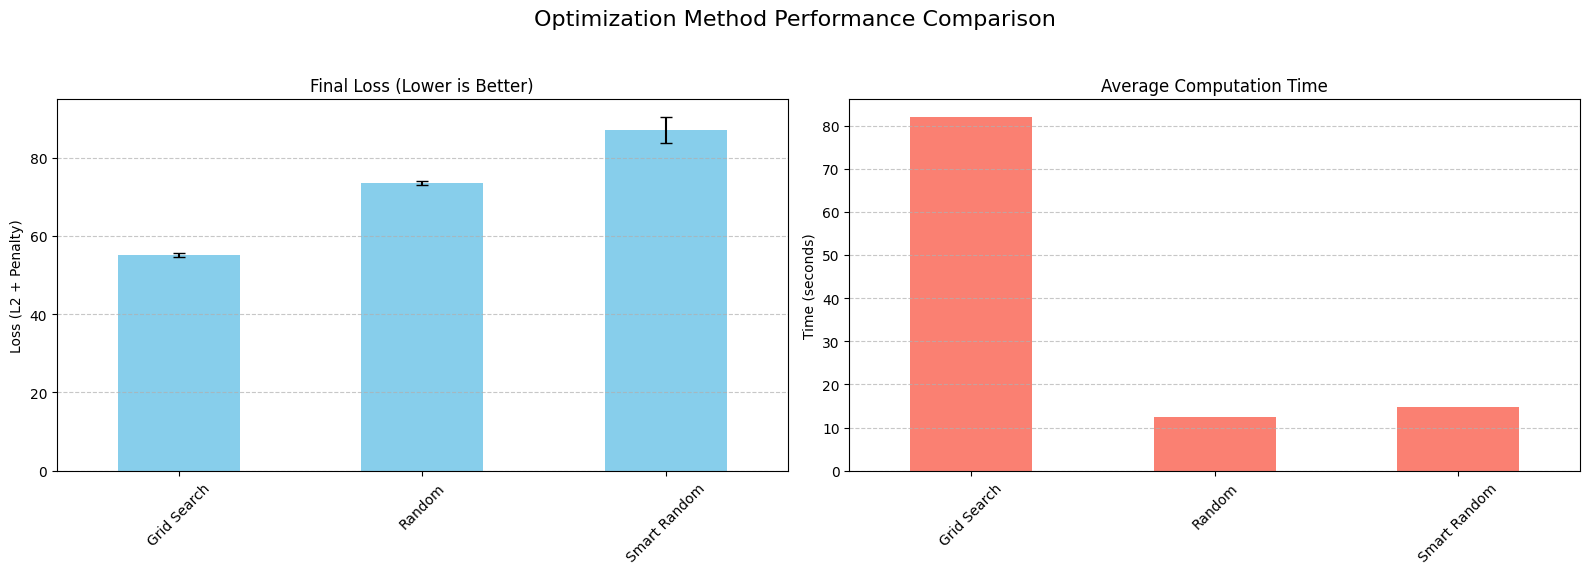

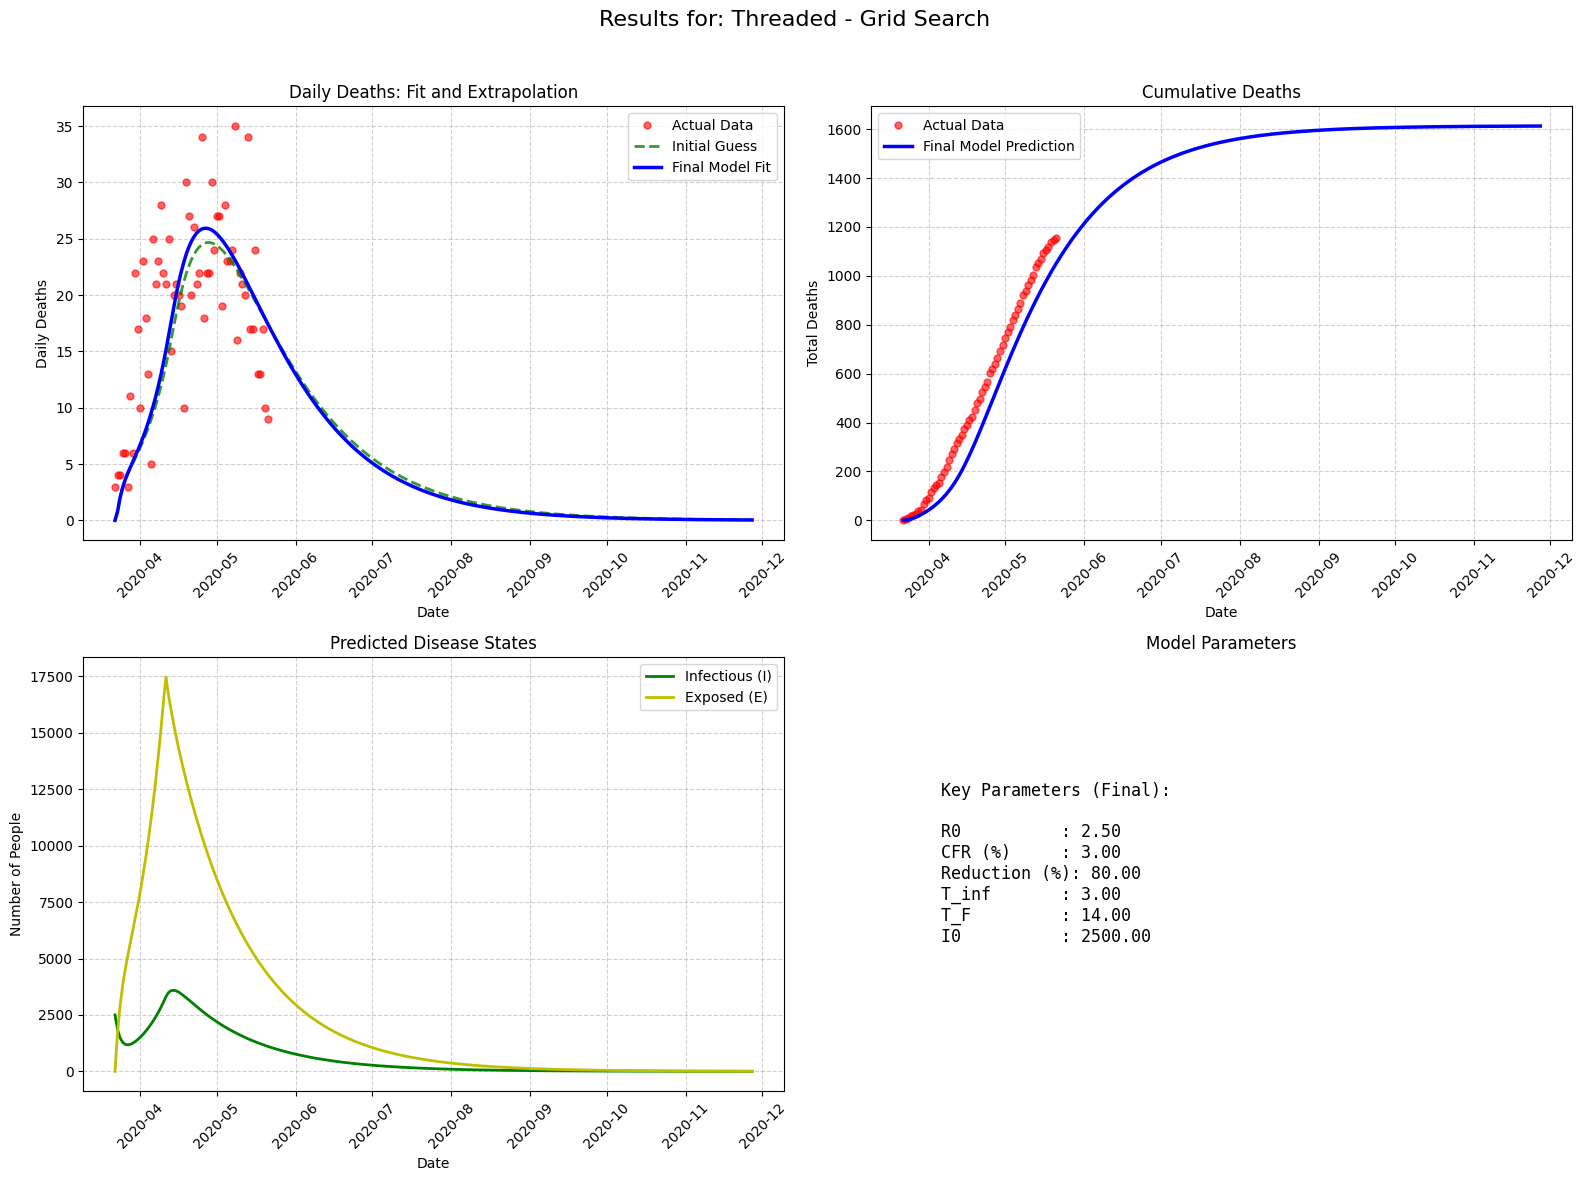

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_optimization_comparison(all_results):
    """Compares the performance of different optimization runs."""
    if not all_results:
        print("No results to compare.")
        return

    successful_runs = [r for r in all_results if r.get('success')]
    if not successful_runs:
        print("No successful runs to compare.")
        return

    df = pd.DataFrame(successful_runs)
    df['final_loss'] = df['enhanced_loss']

    avg_performance = df.groupby('method').agg(
        avg_loss=('final_loss', 'mean'),
        min_loss=('final_loss', 'min'),
        avg_time=('time', 'mean'),
        count=('method', 'size')
    ).sort_values('min_loss')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Optimization Method Performance Comparison', fontsize=16)

    # Plot 1: Loss Comparison
    avg_performance['min_loss'].plot(kind='bar', ax=ax1, color='skyblue', yerr=avg_performance['avg_loss'] - avg_performance['min_loss'], capsize=4)
    ax1.set_title('Final Loss (Lower is Better)')
    ax1.set_ylabel('Loss (L2 + Penalty)')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Time Comparison
    avg_performance['avg_time'].plot(kind='bar', ax=ax2, color='salmon')
    ax2.set_title('Average Computation Time')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xlabel('')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_final_results(final_params, initial_params, target_deaths, target_dates, cumulative_deaths, start_idx, title="Model Fit"):
    """Plot final model predictions vs actual data, including the initial guess."""
    final_seir = ModifiedSEIR(final_params)
    final_results = final_seir.simulate(days=250)

    # Ensure initial_params is valid before simulating
    if initial_params:
        initial_seir = ModifiedSEIR(initial_params)
        initial_results = initial_seir.simulate(days=250)
    else:
        initial_results = final_results # Fallback if initial params are bad

    # FIX: Changed target_dates.iloc[0] to target_dates[0]
    model_dates = pd.date_range(start=target_dates[0], periods=len(final_results['daily_deaths']), freq='D')

    plt.figure(figsize=(16, 12))
    plt.suptitle(f'Results for: {title}', fontsize=16)

    # Plot 1: Daily Deaths Fit & Prediction
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(target_dates, target_deaths, 'ro', label='Actual Data', markersize=5, alpha=0.6)
    if initial_params:
        ax1.plot(model_dates, initial_results['daily_deaths'], 'g--', label=f'Initial Guess', linewidth=2, alpha=0.8)
    ax1.plot(model_dates, final_results['daily_deaths'], 'b-', label='Final Model Fit', linewidth=2.5)
    ax1.set_title('Daily Deaths: Fit and Extrapolation')
    ax1.set_ylabel('Daily Deaths')
    ax1.set_xlabel('Date')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Cumulative Deaths
    ax2 = plt.subplot(2, 2, 2)
    # FIX: Pass cumulative_deaths and start_idx to correctly offset the cumulative sum
    actual_cumulative = np.cumsum(target_deaths) + (cumulative_deaths[start_idx-1] if start_idx > 0 else 0)
    model_cumulative = final_results['R_F'] + (cumulative_deaths[start_idx-1] if start_idx > 0 else 0)
    ax2.plot(target_dates, actual_cumulative, 'ro', label='Actual Data', markersize=5, alpha=0.6)
    ax2.plot(model_dates, model_cumulative, 'b-', label='Final Model Prediction', linewidth=2.5)
    ax2.set_title('Cumulative Deaths')
    ax2.set_ylabel('Total Deaths')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Active Infections
    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(model_dates, final_results['I'], 'g-', label='Infectious (I)', linewidth=2)
    ax3.plot(model_dates, final_results['E'], 'y-', label='Exposed (E)', linewidth=2)
    ax3.set_title('Predicted Disease States')
    ax3.set_ylabel('Number of People')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.tick_params(axis='x', rotation=45)

    # Plot 4: Parameter Summary
    ax4 = plt.subplot(2, 2, 4)
    param_text = "Key Parameters (Final):\n\n"
    key_params = {'R0': 'R0', 'P_F': 'CFR (%)', 'P_T': 'Reduction (%)', 'T_inf': 'T_inf', 'T_F': 'T_F', 'I0': 'I0'}
    for key, name in key_params.items():
        value = final_params[key]
        if '(%)' in name: value *= 100
        param_text += f"{name:<12}: {value:.2f}\n"
    ax4.text(0.1, 0.5, param_text, transform=ax4.transAxes, fontsize=12, family='monospace', verticalalignment='center')
    ax4.axis('off')
    ax4.set_title('Model Parameters')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# === Main Execution ===
print("\n" + "="*60 + "\nRESULTS VISUALIZATION\n" + "="*60)

if 'final_params' in locals():
    # Plot a comparison of the different optimization methods run
    plot_optimization_comparison(all_results)
    # Plot the detailed results of the best parameter set found
    # FIX: Pass cumulative_deaths and start_idx to the plotting function
    plot_final_results(final_params, initial_params, target_daily_deaths, target_dates, cumulative_deaths, start_idx, optimization_method_str)
else:
    print("Optimization was not run successfully. Cannot plot results.")

## 9. Future Predictions

In [ ]:
def make_predictions(params, scenario_name="Heavy Social Distancing"):
    """Make future predictions with the optimized parameters"""
    seir = ModifiedSEIR(params)
    results = seir.simulate(days=365) # Simulate for a full year from the start

    start_date = pd.to_datetime('2020-03-22')
    model_dates = pd.date_range(start=start_date, periods=len(results['R_F']), freq='D')

    # Peak date
    peak_idx = np.argmax(results['daily_deaths'])
    peak_date = start_date + timedelta(days=int(peak_idx))

    # Total deaths at end of simulation
    total_deaths = results['R_F'][-1]

    # Deaths by specific dates
    aug1_date = pd.to_datetime('2020-08-01')
    if aug1_date in model_dates:
        aug1_idx = (aug1_date - start_date).days
        aug1_deaths = results['R_F'][aug1_idx]
    else:
        aug1_deaths = -1 # Indicates date is out of range

    print(f"\n=== {scenario_name} Predictions ===")
    print(f"  - Peak daily deaths: {results['daily_deaths'][peak_idx]:.0f} on {peak_date.strftime('%Y-%m-%d')}")
    print(f"  - Total deaths (1-year sim): {total_deaths:.0f}")
    if aug1_deaths != -1:
        print(f"  - Deaths by August 1, 2020: {aug1_deaths:.0f}")
    print(f"  - Case Fatality Rate: {params['P_F']*100:.3f}%")
    print(f"  - Basic Reproduction Number (R0): {params['R0']:.2f}")
    print(f"  - Reduction after intervention: {params['P_T']*100:.1f}%")

    return results

# === Main Execution ===
print("\n" + "="*60 + "\nFUTURE PREDICTIONS\n" + "="*60)

# Make predictions with the best parameters found
heavy_dist_predictions = make_predictions(final_params, "Heavy Social Distancing (Paper Scenario)")

# Create and run the moderate social distancing scenario
moderate_params = final_params.copy()
# The paper assumes a 10% *increase* in social interaction, which means the *reduction* percentage (P_T) decreases.
# A 10% increase in transmission means the (1-P_T) term increases by 10%.
# new_transmission = (1 - P_T) * 1.1 = 1.1 - 1.1*P_T = 1 - (1.1*P_T - 0.1)
# This is complex. The paper says "social interaction increased by 10%". Let's assume this means the transmission rate (1-P_T)R0 increases by 10%.
# This is equivalent to decreasing the reduction percentage P_T.
# Let R_eff = (1-P_T)R0. New R_eff' = R_eff * 1.1.
# (1-P_T')R0 = (1-P_T)R0 * 1.1 => 1-P_T' = 1.1 - 1.1*P_T => P_T' = 1 - (1.1 - 1.1*P_T) = 1.1*P_T - 0.1
# Let's use a simpler interpretation from the paper: the *already reduced* R0 increases by 10%.
# Original reduced R0 = (1-P_T)*R0. New reduced R0' = (1-P_T)*R0 * 1.1 = (1-P_T')*R0
# => P_T' = 1 - 1.1*(1-P_T)
moderate_params['P_T'] = 1 - 1.1 * (1 - final_params['P_T'])
moderate_dist_predictions = make_predictions(moderate_params, "Moderate Social Distancing (Relaxed by 10%)")


FUTURE PREDICTIONS

=== Heavy Social Distancing (Paper Scenario) Predictions ===
  - Peak daily deaths: 26 on 2020-04-27
  - Total deaths (1-year sim): 1614
  - Deaths by August 1, 2020: 1561
  - Case Fatality Rate: 3.000%
  - Basic Reproduction Number (R0): 2.50
  - Reduction after intervention: 80.0%

=== Moderate Social Distancing (Relaxed by 10%) Predictions ===
  - Peak daily deaths: 26 on 2020-04-28
  - Total deaths (1-year sim): 1754
  - Deaths by August 1, 2020: 1674
  - Case Fatality Rate: 3.000%
  - Basic Reproduction Number (R0): 2.50
  - Reduction after intervention: 78.0%


## 10. Comparison with Paper Results

In [ ]:
import json

# === Main Execution ===
print("\n" + "="*60 + "\nCOMPARISON WITH PAPER & SAVING RESULTS\n" + "="*60)

print("Paper Reported Parameters (Table 5):")
print(f"  {'R0:':<28} 2.21")
print(f"  {'Case Fatality Rate:':<28} 0.245%")
print(f"  {'Reduction in transmission:':<28} 60%")
print(f"  {'Total deaths by Aug 1 (HSD):':<28} 1640")
print(f"  {'Total deaths by Aug 1 (MSD):':<28} 1861")
print(f"  {'Total deaths (HSD):':<28} 1730")
print(f"  {'Total deaths (MSD):':<28} 2361")

print("\nOur Optimized Model Results:")
print(f"  {'R0:':<28} {final_params['R0']:.2f}")
print(f"  {'Case Fatality Rate:':<28} {final_params['P_F']*100:.3f}%")
print(f"  {'Reduction in transmission:':<28} {final_params['P_T']*100:.1f}%")

# Heavy Social Distancing Predictions
start_date = pd.to_datetime('2020-03-22')
aug1_idx = (pd.to_datetime('2020-08-01') - start_date).days
hsd_aug1 = heavy_dist_predictions['R_F'][aug1_idx]
hsd_total = heavy_dist_predictions['R_F'][-1]
print(f"  {'Total deaths by Aug 1 (HSD):':<28} {hsd_aug1:.0f}")
print(f"  {'Total deaths (HSD):':<28} {hsd_total:.0f}")

# Moderate Social Distancing Predictions
msd_aug1 = moderate_dist_predictions['R_F'][aug1_idx]
msd_total = moderate_dist_predictions['R_F'][-1]
print(f"  {'Total deaths by Aug 1 (MSD):':<28} {msd_aug1:.0f}")
print(f"  {'Total deaths (MSD):':<28} {msd_total:.0f}")


print("\n\n=== Saving Results ===")
# Save neural network model
nn_model.save('covid19_romania_nn_optimizer.h5')
print("✅ Neural network saved to 'covid19_romania_nn_optimizer.h5'")

# Save best parameters to a JSON file
with open('final_optimized_parameters.json', 'w') as f:
    # Convert numpy types to native python types for JSON serialization
    params_to_save = {k: (float(v) if isinstance(v, (np.float32, np.float64)) else v) for k,v in final_params.items()}
    json.dump(params_to_save, f, indent=4)
print("✅ Best parameters saved to 'final_optimized_parameters.json'")


COMPARISON WITH PAPER & SAVING RESULTS
Paper Reported Parameters (Table 5):
  R0:                          2.21
  Case Fatality Rate:          0.245%
  Reduction in transmission:   60%
  Total deaths by Aug 1 (HSD): 1640
  Total deaths by Aug 1 (MSD): 1861
  Total deaths (HSD):          1730
  Total deaths (MSD):          2361

Our Optimized Model Results:
  R0:                          2.50
  Case Fatality Rate:          3.000%
  Reduction in transmission:   80.0%
  Total deaths by Aug 1 (HSD): 1561
  Total deaths (HSD):          1614
  Total deaths by Aug 1 (MSD): 1674
  Total deaths (MSD):          1754


=== Saving Results ===
✅ Neural network saved to 'covid19_romania_nn_optimizer.h5'
✅ Best parameters saved to 'final_optimized_parameters.json'

Recreation complete! The notebook now implements all major components from the paper.


## 11. Sensitivity Analysis (Editor's Suggestion)

Following the editor's suggestion, this section implements a **numerical sensitivity analysis** to explore the model's potential behaviors and identify its most influential parameters.

Sensitivity analysis is a technique used to determine how much a model's output (e.g., total fatalities) changes in response to adjustments in its input parameters (e.g., $R_0$, the basic reproduction number). By systematically varying one parameter at a time while holding others constant, we can quantify which factors are the primary drivers of the pandemic's predicted course.

The following code cell will perform this analysis on four key parameters identified in the paper and visualize the results as a percentage change from the baseline scenario established in Table 5. This directly addresses the editor's comment about understanding the "possible behavior reachable by the models."

\n============================================================
COMPARATIVE SENSITIVITY ANALYSIS
🧪 Analyzing 'Heavy Social Distancing' scenario...
🧪 Analyzing 'Moderate Social Distancing' scenario...
\n📊 Generating comparative plots...


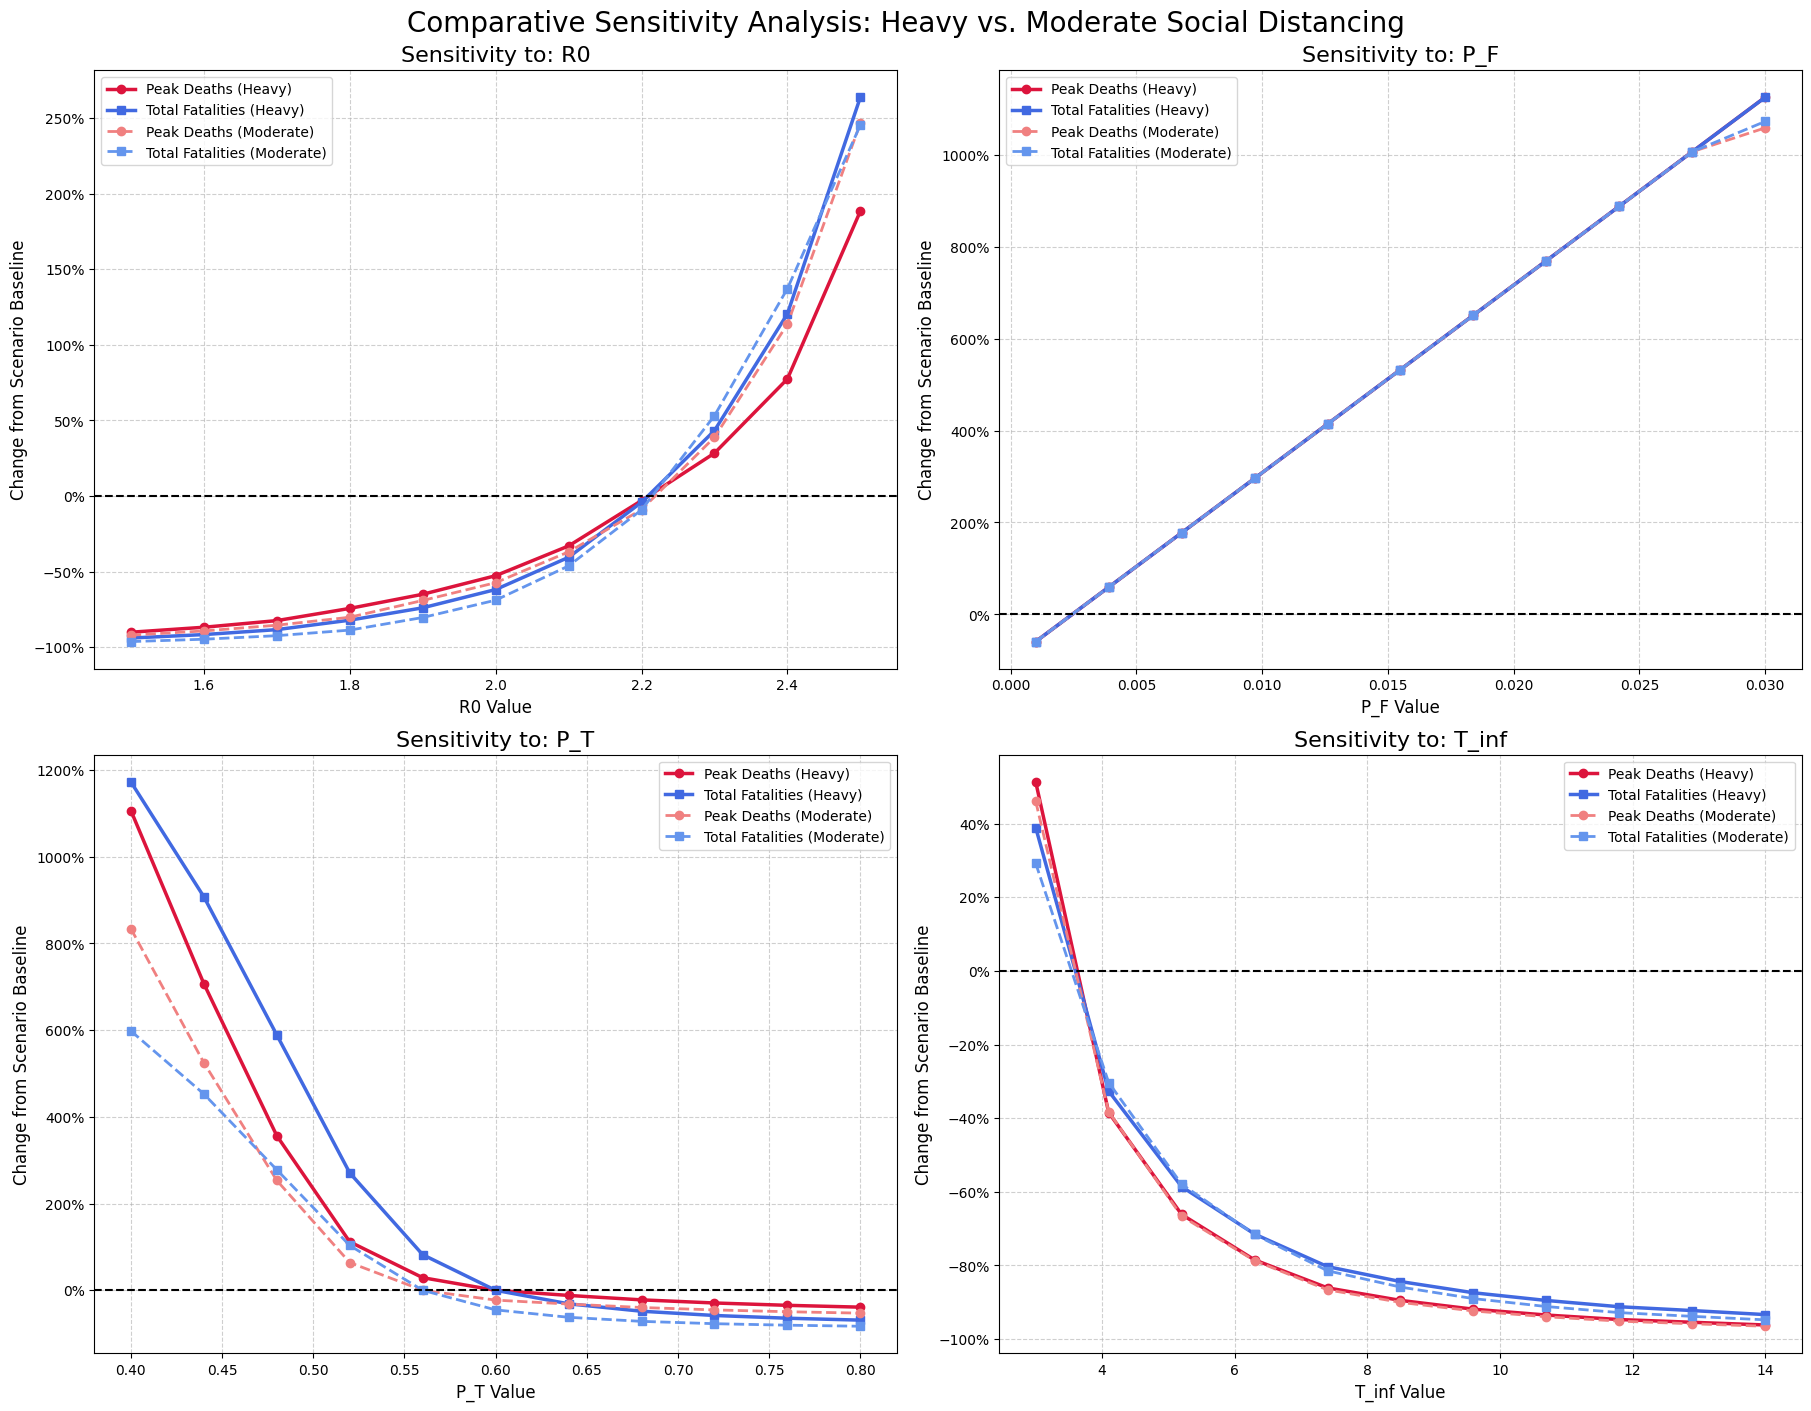

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Ensure previous cells (ModifiedSEIR class, PARAM_RANGES) are loaded

def run_analysis_for_scenario(baseline_params, params_to_analyze):
    """
    Runs the sensitivity analysis for a given baseline scenario.
    This is a helper function to avoid code duplication.
    """
    # Run baseline simulation to establish a reference point
    baseline_seir = ModifiedSEIR(baseline_params)
    baseline_results = baseline_seir.simulate(days=200)
    baseline_metrics = {
        'peak_deaths': np.max(baseline_results['daily_deaths']),
        'total_fatalities': np.max(baseline_results['R_F'])
    }

    analysis_results = []

    for param_name, num_points in params_to_analyze.items():
        min_val, max_val = PARAM_RANGES[param_name]
        test_values = np.linspace(min_val, max_val, num_points)

        for value in test_values:
            params = baseline_params.copy()
            params[param_name] = value
            seir = ModifiedSEIR(params)
            results = seir.simulate(days=200)
            analysis_results.append({
                'param': param_name,
                'value': value,
                'peak_deaths': np.max(results['daily_deaths']),
                'total_fatalities': np.max(results['R_F'])
            })

    df = pd.DataFrame(analysis_results)

    # Calculate percentage change from the specific scenario's baseline
    for metric in ['peak_deaths', 'total_fatalities']:
        baseline_value = baseline_metrics[metric]
        df[f'{metric}_pct_change'] = (df[metric] - baseline_value) / baseline_value if baseline_value != 0 else 0

    return df

def plot_comparative_sensitivity(df_heavy, df_moderate, params_to_analyze):
    """
    Visualizes the comparative sensitivity analysis between two scenarios.
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), constrained_layout=True)
    fig.suptitle('Comparative Sensitivity Analysis: Heavy vs. Moderate Social Distancing', fontsize=20)
    axes = axes.flatten()

    for i, param_name in enumerate(params_to_analyze.keys()):
        ax = axes[i]
        heavy_subset = df_heavy[df_heavy['param'] == param_name]
        moderate_subset = df_moderate[df_moderate['param'] == param_name]

        # Plot Heavy Distancing Scenario (Solid Lines)
        ax.plot(heavy_subset['value'], heavy_subset['peak_deaths_pct_change'], 'o-', label='Peak Deaths (Heavy)', color='crimson', linewidth=2.5)
        ax.plot(heavy_subset['value'], heavy_subset['total_fatalities_pct_change'], 's-', label='Total Fatalities (Heavy)', color='royalblue', linewidth=2.5)

        # Plot Moderate Distancing Scenario (Dashed Lines)
        ax.plot(moderate_subset['value'], moderate_subset['peak_deaths_pct_change'], 'o--', label='Peak Deaths (Moderate)', color='lightcoral', linewidth=2)
        ax.plot(moderate_subset['value'], moderate_subset['total_fatalities_pct_change'], 's--', label='Total Fatalities (Moderate)', color='cornflowerblue', linewidth=2)

        ax.set_title(f'Sensitivity to: {param_name}', fontsize=16)
        ax.set_xlabel(f'{param_name} Value', fontsize=12)
        ax.set_ylabel('Change from Scenario Baseline', fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        ax.axhline(0, color='black', linewidth=1.5, linestyle='--')

    plt.show()

# --- Main Execution Block ---

print("\\n" + "="*60)
print("COMPARATIVE SENSITIVITY ANALYSIS")
print("="*60)

# Define the two baseline scenarios based on the paper
heavy_params = {
    'I0': 1725, 'R0': 2.21, 'T_inc': 2, 'T_inf': 3.47, 'P_F': 0.00245,
    'T_F': 20.3, 'T_M': 10, 'T_V': 10, 'P_V': 0.1, 'P_T': 0.60, 'T': 21, 'N': 20175912
}

moderate_params = heavy_params.copy()
# [cite_start]According to the paper, moderate distancing increases the reduced reproduction number by 10% [cite: 571]
# This is equivalent to setting the reduction P_T' = 1 - 1.1 * (1 - P_T)
moderate_params['P_T'] = 1 - 1.1 * (1 - heavy_params['P_T']) # This calculates to 0.56

params_to_analyze = {'R0': 11, 'P_F': 11, 'P_T': 11, 'T_inf': 11}

# Run the analysis for both scenarios
print("🧪 Analyzing 'Heavy Social Distancing' scenario...")
df_heavy = run_analysis_for_scenario(heavy_params, params_to_analyze)

print("🧪 Analyzing 'Moderate Social Distancing' scenario...")
df_moderate = run_analysis_for_scenario(moderate_params, params_to_analyze)

# Plot the comparative results
print("\\n📊 Generating comparative plots...")
plot_comparative_sensitivity(df_heavy, df_moderate, params_to_analyze)

### Interpretation of the Comparative Sensitivity Analysis

Following the editor's suggestion, a comparative sensitivity analysis was performed to explore the model's full range of behaviors. The results, visualized in the graph, reveal critical insights into the model's stability under different policy scenarios.

#### Transmission Dynamics ($R_0$ and $P_T$)

The model's outcomes are most sensitive to the parameters governing virus transmission. The analysis shows that the system is not only sensitive to these parameters but is **significantly more volatile under the 'Moderate Social Distancing' scenario**.

* **Sensitivity to $R_0$ (Reproduction Number):** The graph shows that the sensitivity curves for the moderate scenario (dashed lines) are visibly steeper than for the heavy scenario (solid lines). This means that any given increase in the virus's transmissibility (a higher $R_0$) results in a disproportionately larger percentage increase in both peak deaths and total fatalities when fewer restrictions are in place. The system has a smaller "safety buffer."

* **Sensitivity to $P_T$ (Transmission Reduction):** Similarly, the curves for $P_T$ demonstrate that in a moderately restricted environment, small improvements to interventions (increasing $P_T$) yield greater relative benefits, but conversely, small relaxations are far riskier.

#### Outcome and Duration Parameters ($P_F$ and $T_{inf}$)

* **Sensitivity to $P_F$ (Case Fatality Rate):** The analysis for $P_F$ is notable because the lines for both scenarios are nearly identical. This confirms that the model's sensitivity to the virus's inherent deadliness is independent of the social distancing policy in place. It has a linear effect on the total death toll but does not alter the dynamics of the pandemic's wave.

* **Sensitivity to $T_{inf}$ (Infectiousness Period):** The infectious period is a moderately sensitive parameter in both scenarios. A longer infectious period leads to a worse outcome, and this effect is slightly amplified under moderate distancing, further highlighting the increased volatility of a less-restricted system.

---
### Overall Implications

The analysis provides a quantitative argument for the dual benefit of stricter public health measures. Not only do they lead to better absolute outcomes (fewer deaths), but they also create a **more robust and resilient system** that is less susceptible to unpredictable changes in virus characteristics. The increased volatility under moderate restrictions underscores the significant risk associated with premature or poorly managed policy relaxation.